In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

In [3]:
sns.set_style("whitegrid")

In [4]:
def plot_model_comparison(
    paths: list[str], 
    labels: list[str], 
    title: str, 
    subtitle: str = None, 
    loss_indices: list[int] = None,
    include_train: bool = True,
    include_val: bool = True,
):
    if len(paths) != len(labels):
        raise Exception("Did not provide an equal number of paths and labels!")

    figsize = (12, 6) if include_train + include_val > 1 else (10, 6)
    fig, ax = plt.subplots(nrows=1, ncols=(include_train + include_val), figsize=figsize)
    if loss_indices is None: loss_indices = [0] * len(paths)

    for idx, path in enumerate(paths):
        label = labels[idx]
        checkpoint = torch.load(path, map_location=torch.device("cpu"))

        train_losses = [loss[loss_indices[idx]].item() for loss in checkpoint["train_losses"]]
        train_epochs = np.arange(1, len(train_losses) + 1)

        validation_losses = [loss[loss_indices[idx]].item() for loss in checkpoint["validation_losses"]]
        val_epochs = np.arange(1, len(validation_losses) + 1)

        if (include_train): sns.lineplot(
            x=train_epochs, 
            y=train_losses, 
            label=f"Train {label}", 
            color=f"C{idx}",
            ax=ax[0] if include_val else ax,
        )
        if (include_val): sns.lineplot(
            x=val_epochs, 
            y=validation_losses, 
            label=f"Validation {label}", 
            color=f"C{idx}",
            ax=ax[1] if include_train else ax,
        )

    if include_train + include_val > 1:
        title_axes = ax[0] if include_train + include_val > 1 else ax
        plt.text(x=0.5, y=1.025, s=title, fontsize=16, ha="center", va="bottom", transform=title_axes.transAxes)
    else:
        plt.title(title, pad=24, fontsize=16)

    if subtitle:
        subtitle_axes = ax[1] if include_train + include_val > 1 else ax
        plt.text(x=0.5, y=1.025, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom", transform=subtitle_axes.transAxes)

    plt.xlabel("Training Epoch #")
    plt.ylabel("Mean Epoch Loss")
    plt.legend()
    plt.show()

In [64]:
def plot_scores_comparison(
    scores,
    labels: tuple[str], 
    title: str = None,
    subtitle: str = None,
    bins: int = 20,
):
    fig, ax = plt.subplots()

    for idx, score_list in enumerate(scores):
        mean = np.mean(score_list)
        median = np.median(score_list)
        label = f"{labels[idx]} (mean={mean:.3f}, median={median:.3f})"
        sns.histplot(score_list, ax=ax, label=label, color=f"C{idx}", alpha=0.5, bins=bins)

    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Datapoint Count")
    plt.xlim([-0.03, 1.02])

    if (title):
        pad = 24 if subtitle else None
        ax.set_title(title, pad=pad)
    if (subtitle):
        subtitle_x = 0.5
        subtitle_y = plt.gca().get_ylim()[1] + 3
        plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")

    ax.legend()
    plt.show()

In [6]:
def read_list_from_file(file_path: str, data_type=float):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            element = data_type(line.strip())
            data.append(element)
    return data

# Prompting

## Effect of Prompt Type

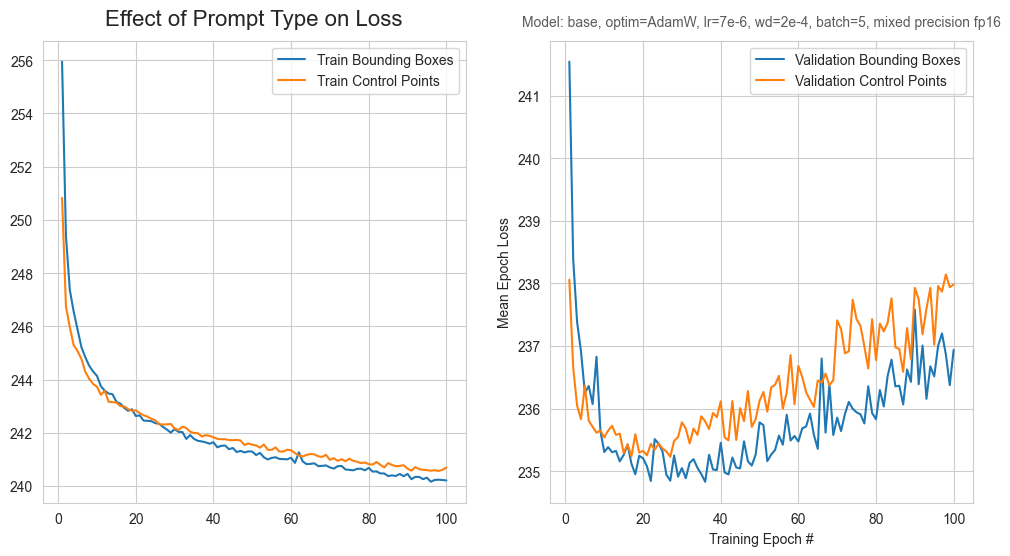

In [76]:
plot_model_comparison(
    [
        "./prompts/last_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.pth",
        "./prompts/last_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.pth",
    ],
    ["Bounding Boxes", "Control Points"],
    title="Effect of Prompt Type on Loss",
    subtitle="Model: base, optim=AdamW, lr=7e-6, wd=2e-4, batch=5, mixed precision fp16",
)

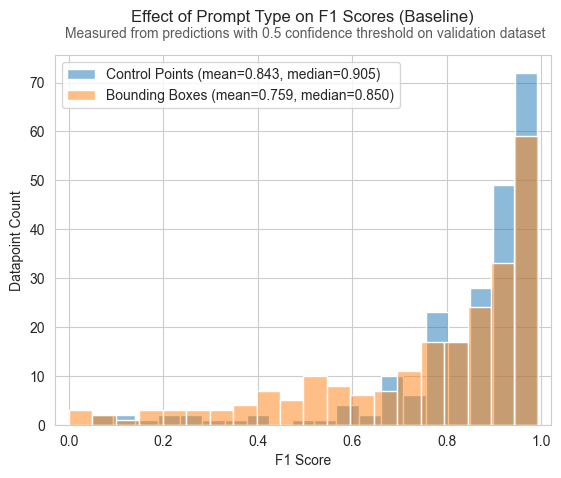

In [75]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_original_base_bbox_10.txt"),
    ), 
    ("Control Points", "Bounding Boxes"),
    title="Effect of Prompt Type on F1 Scores (Baseline)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset"
)

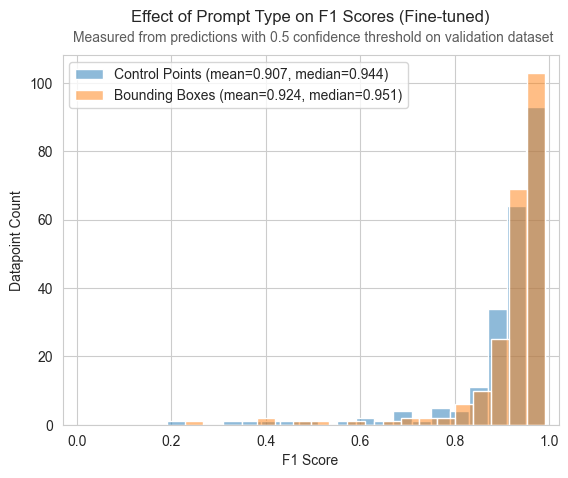

In [74]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.txt"),
    ), 
    ("Control Points", "Bounding Boxes"),
    title="Effect of Prompt Type on F1 Scores (Fine-tuned)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset"
)

## Effect of Fine-tuning

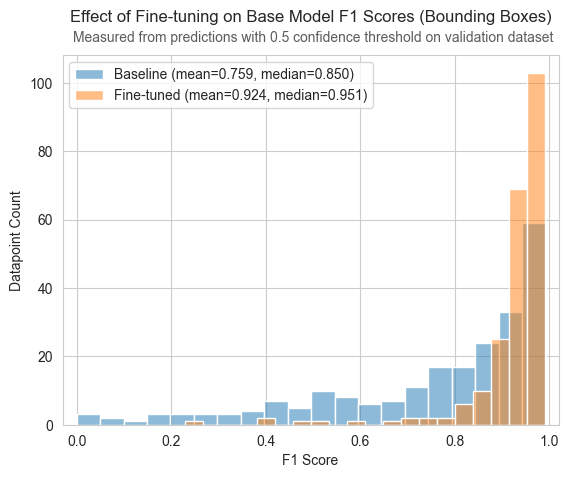

In [72]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_bbox_10.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.txt"),
    ), 
    ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning on Base Model F1 Scores (Bounding Boxes)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

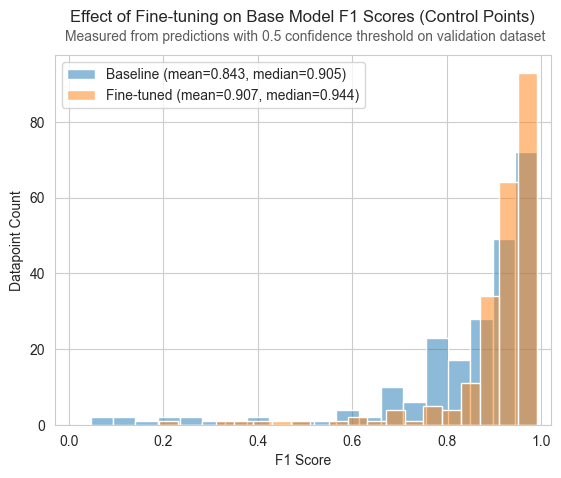

In [73]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
    ), 
    ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning on Base Model F1 Scores (Control Points)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

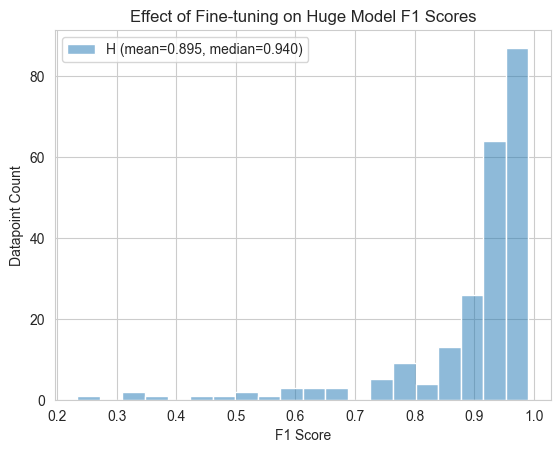

In [25]:
plot_scores_comparison(
    (
        # read_list_from_file("./prompts/f1_scores_original_huge.txt"),
        read_list_from_file("./prompts/f1_scores_huge_AdamW_lr=7e-06_wd=0.0002_bs=3_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
    ), 
    ("Huge Model"),
    # ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning on Huge Model F1 Scores",
    # subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)